# Detekcija emocija

// todo: opisati projekat

## Preprocesiranje teksta
 
// blabla

In [45]:
import re
import io
import json
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras_preprocessing.sequence import pad_sequences
from textblob import TextBlob

In [48]:
def _normalizeText(text: str) -> str:
    text = _removeNumbers(text.lower())
    text = _removeStopWords(text)
    text = _cleanAbbreviations(_cleanLinks(text))
    text = _removeSpecialChars(text)
    text = _removePunctuation(text)
    text = _lemmatization(text)
    return text

def _correctTypos(text: str) -> str:
    blob = TextBlob(text).correct()
    return str(blob)
 
def _cleanLinks(text):
    """Cleans links and HTML tags from text."""
    pattern = re.compile(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    clean = re.compile('<.*?>')
    text = re.sub(clean, '', text)
    text = re.sub(pattern, '', text)
    return text

def _cleanAbbreviations(text):
    text = re.sub(r"i['\s]?m\s", "i am ", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"\su['\s]r\s", " you are ", text)
    text = re.sub(r"he['\s]?s\s", "he is ", text)
    text = re.sub(r"she['\s]?s", "she is", text)
    text = re.sub(r"that['\s]?s", "that is", text)
    text = re.sub(r"what['\s]?s", "what is", text)
    text = re.sub(r"where['\s]?s", "where is", text)
    text = re.sub(r"[\'\s]ll\s", " will ", text)
    text = re.sub(r"[\'\s]ll\s", " will ", text)
    text = re.sub(r"[\'\s]ve\s", " have ", text)
    text = re.sub(r"[\'\s]re\s", " are ", text)
    text = re.sub(r"[\'\s]d\s", " would ", text)
    text = re.sub(r"won['\s]?t", "will not", text)
    text = re.sub(r"don['\s]?t", "do not", text)
    text = re.sub(r"didn['\s]?t", "did not", text)
    text = re.sub(r"can['\s]?t", "can not", text)
    text = re.sub(r"couldn['\s]?t", "could not", text)
    text = re.sub(r"haven['\s]?t", "have not", text)
    text = re.sub(r"\sw(?:\s|$)", " with ", text)
    text = re.sub(r"\stbh\s", " to be honest ", text)
    #TODO: add more
    return text

def _removeSpecialChars(text):
    text = re.sub(r"[@#$%^&*(){}/;`~<>+=-]", "", text)
    return text

def _removeNumbers(text: str) -> str:
    return re.sub(r"\d+", '', text)

def _removePunctuation(text):
    tokens = word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    text = ' '.join(words)
    return text

def preprocess(inputData: dict) -> tuple:
    inputData['sentiment'] = inputData['sentiment'].replace(
    {'joy': 0, 'anger': 1, 'love': 2, 'sadness': 3, 'fear': 4, 'surprise': 5})
    yinput = to_categorical(inputData['sentiment'].values)
    inputData['text'] = inputData['text'].map(_normalizeText)
    xinput = inputData['text'].values
    return (xinput, yinput)

def makeTokenizer(xtrain: list):
    tokenizer = Tokenizer(15212, oov_token='UNK')
    tokenizer.fit_on_texts(xtrain)
    tokenizer_json = tokenizer.to_json()
    with io.open('preprocessing/tokenizer.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    return
    
def textToSequences(text: list):
    tokenizer = None
    with open('preprocessing/tokenizer.json') as f:
        data = json.load(f)
        tokenizer = tokenizer_from_json(data)
        text = pad_sequences(tokenizer.texts_to_sequences(text), maxlen=80, padding='post')
        return text

### Stop words

In [46]:
stop_words = set(stopwords.words('english'))

def _removeStopWords(text: str) -> str:
    word_tokens = word_tokenize(text)
    filtered_text = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered_text)

### Lemmatization

In [47]:
lemmatizer = WordNetLemmatizer()

def _lemmatization(text: str) -> str:
    word_tokens = word_tokenize(text)
    text = [lemmatizer.lemmatize(y) for y in word_tokens]
    return " ".join(text)

## Kreiranje modela

// blabla

In [35]:
import pandas as pd
import io
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

In [49]:
def trainModel():
    train = pd.read_csv('train.txt', sep=';', names=['text', 'sentiment'])
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    val = pd.read_csv('val.txt', sep=';', names=['text', 'sentiment'])
    _saveClassDistribution(train)

    xtrain, ytrain = preprocess(train)
    xtest, ytest = preprocess(test)
    xval, yval = preprocess(val)

    makeTokenizer(xtrain)
    xtrain = textToSequences(xtrain)
    xtest = textToSequences(xtest)
    xval = textToSequences(xval)

    model = _makeModel()
    hist = model.fit(xtrain, ytrain, epochs=15, validation_data=(xval, yval))
    model.save('model\emotions.h5')
    print("Model saved on disk.")

    _testModel(model, xtest, ytest)
    _saveFigures(hist)
    plot_model(model=model, to_file='model\model.png', show_layer_names=False, show_shapes=True, show_layer_activations=True)

    return model

def _makeModel():
    model = Sequential()
    model.add(Embedding(input_dim=15212, output_dim=64, input_length=80))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(6, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

def _testModel(model, xtest, ytest):
    print("Testing the model...")
    print("The result obtained is:\n")
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    xtest, ytest = preprocess(test)
    xtest = textToSequences(xtest)
    model.evaluate(xtest, ytest)


    yprediction = model.predict(xtest)
    yprediction = np.argmax(yprediction, axis=1)
    ytest = np.argmax(ytest, axis=1)
    result = confusion_matrix(ytest, yprediction, normalize='pred')
    print(result)

    classes = ["joy", "anger", "love", "sadness", "fear", "surprise"]
    df_cfm = pd.DataFrame(result, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sn.heatmap(df_cfm, annot=True)
    cfm_plot.figure.savefig("evaluation\cfm.png")
    print("\nConfusion matrix saved on disk.\n")

    getClassificationReport(model)


def getClassificationReport(model):
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    xtest, ytest = preprocess(test)
    xtest = textToSequences(xtest)
    yprediction = model.predict(xtest)
    yprediction = np.argmax(yprediction, axis=1)
    ytest = np.argmax(ytest, axis=1)
    report = classification_report(ytest, yprediction)
    print(report)
    with io.open('evaluation/classificationreport.txt', 'w', encoding='utf-8') as f:
        f.write(report)


def _saveFigures(hist):
    plt.figure(figsize=(15, 10))
    plt.plot(hist.history['accuracy'], c='b', label='train')
    plt.plot(hist.history['val_accuracy'], c='r', label='validation')
    plt.title("Model Accuracy vs Epochs")
    plt.xlabel("EPOCHS")
    plt.ylabel("ACCURACY")
    plt.legend(loc='lower right')
    plt.savefig('evaluation/accuracy.jpg')

    plt.figure(figsize=(15, 10))
    plt.plot(hist.history['loss'], c='orange', label='train')
    plt.plot(hist.history['val_loss'], c='g', label='validation')
    plt.title("Model Loss vs Epochs")
    plt.xlabel("EPOCHS")
    plt.ylabel("LOSS")
    plt.legend(loc='upper right')
    plt.savefig('evaluation\loss.jpg')

def _saveClassDistribution(dataset):
    plt.figure(figsize=(15, 10))
    pie = dataset.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')
    pie.figure.set_size_inches(15, 10)
    pie.figure.legend(loc='lower right')
    pie.figure.savefig("evaluation/classdistribution.jpg")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 80, 64)            973568    
                                                                 
 dropout_4 (Dropout)         (None, 80, 64)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 80, 128)          66048     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

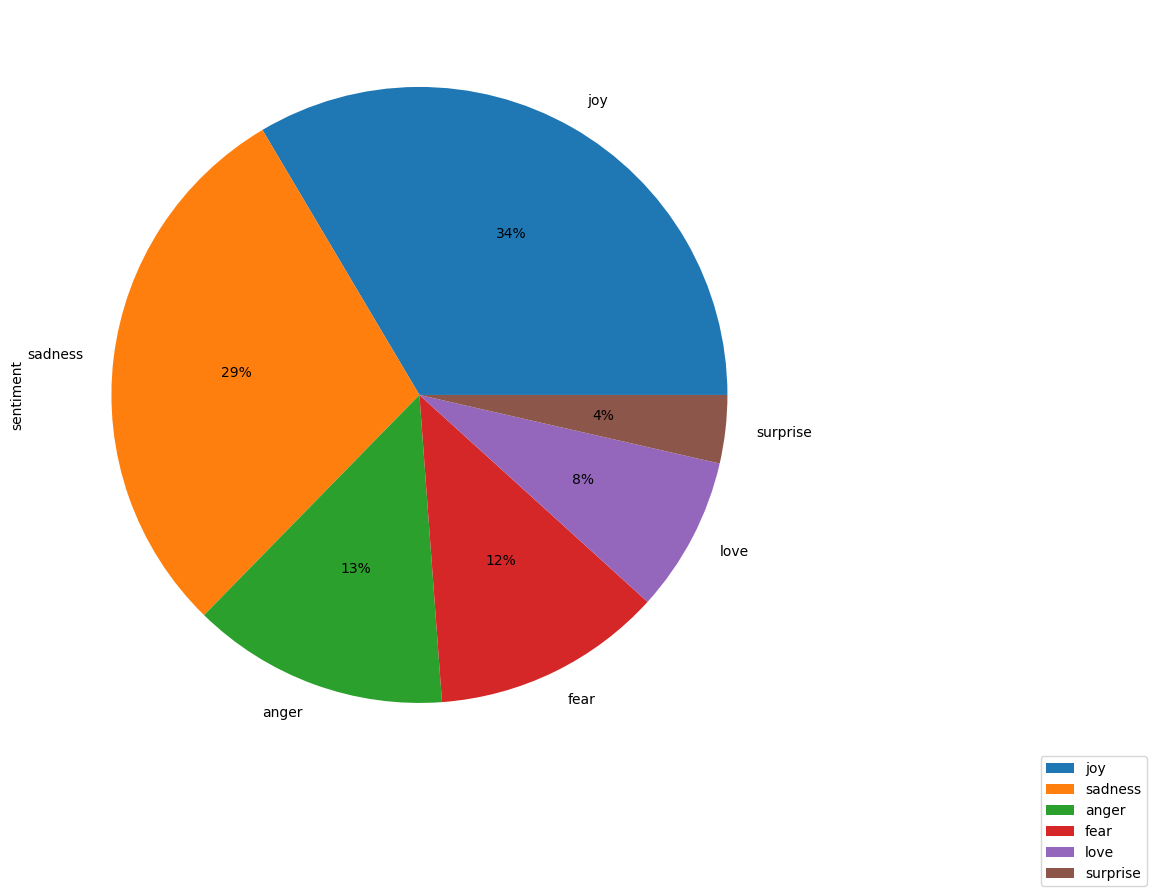

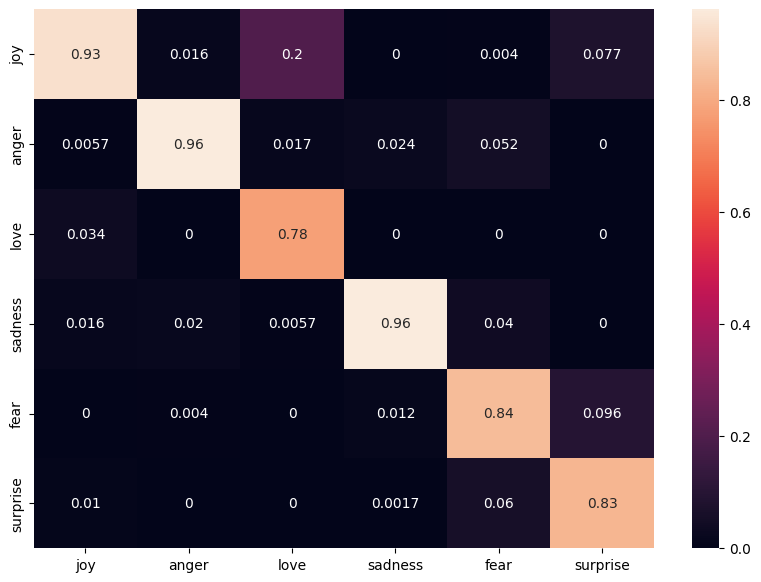

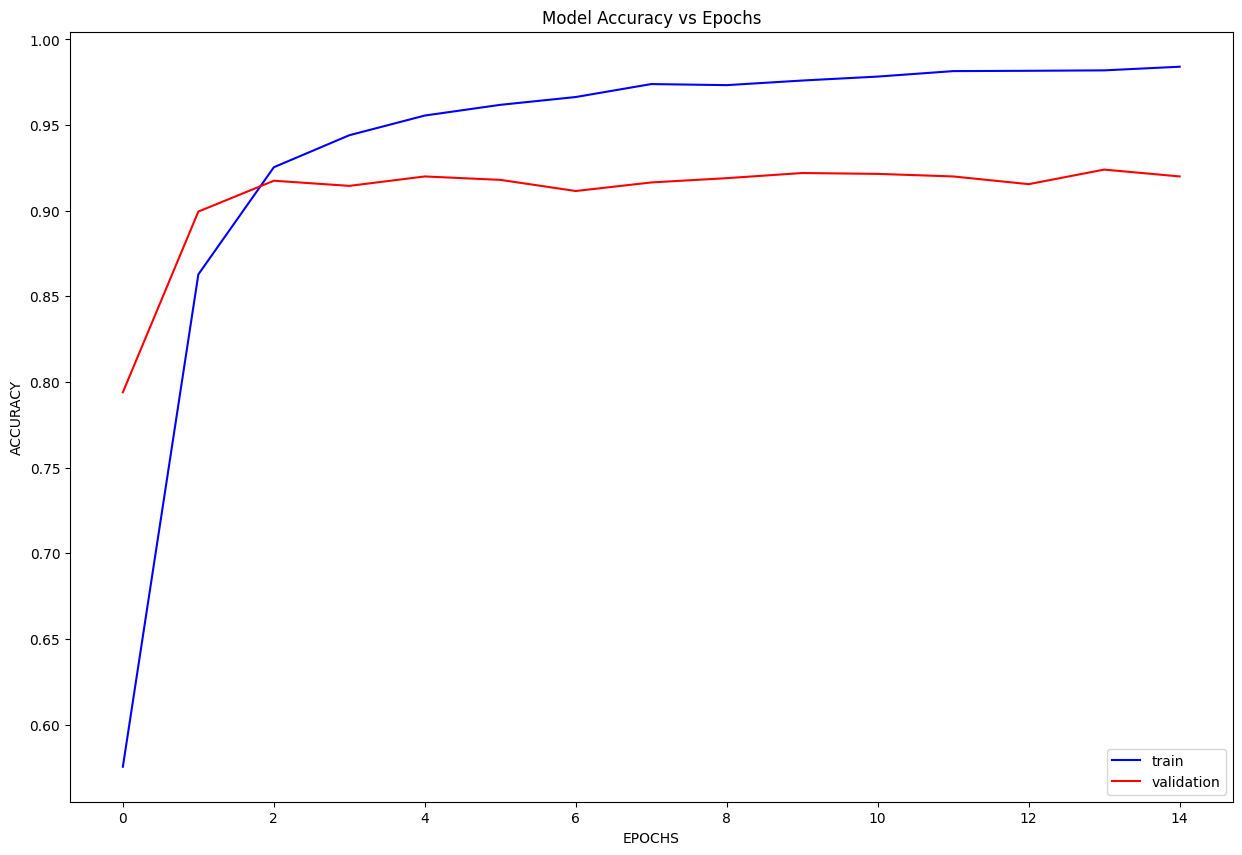

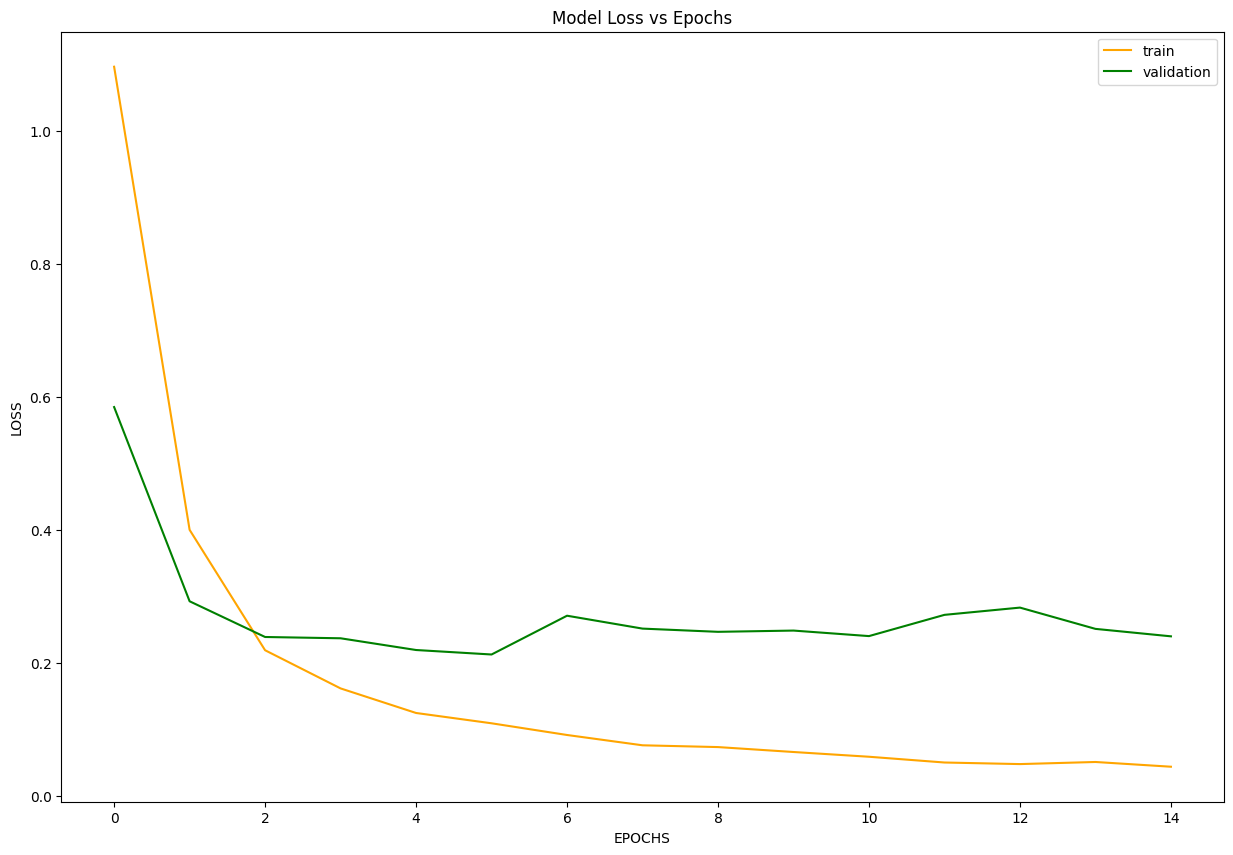

In [50]:
model = trainModel()   